# Centralized learning for ECG Arrhythmia detection


In [1]:
import configparser
import os
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import wandb
from dotenv import load_dotenv
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger

from dataset_utils import Cinc2017DataModule
from model import DenseNetEcgModule

/home/g113056077/.pyenv/versions/awin-ecg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config


In [2]:
load_dotenv()
wandb_mode = os.getenv("WANDB_MODE")

config = configparser.ConfigParser()
config.read("config.ini")
dst_freq = config.getint("data_preprocessing", "dst_freq")
dst_time = config.getint("data_preprocessing", "dst_time")
dst_length = dst_freq * dst_time

MAX_EPOCHS = 50

## Prepare the Dataset


In [3]:
BATCH_SIZE = 64
dm = Cinc2017DataModule(batch_size=BATCH_SIZE)

## Create the Model


In [4]:
model = DenseNetEcgModule(
    max_epochs=MAX_EPOCHS,
    num_classes=dm.num_classes,
    input_length=dst_length,
    lr_scheduler_mode="multi_step",
    lr=1e-3,
    # min_lr = 1e-4,
    show_valid_cm=True,
    growth_rate=32,
    block_config=(6, 4, 4, 12, 8, 8, 24),
    num_init_features=64,
    bn_size=2,
    db_drop_rate=0.2,
    memory_efficient=False,
    compression_factor=0.5,
)

# the number of features per denseblock:
# (64 + 4 * 16) // 2 = 64
# (64 + 4 * 16) // 2 = 64
# (64 + 12 * 16) // 2 = 128
# (128 + 8 * 16) // 2 = 128
# (128 + 8 * 16) // 2 = 128
# (256 + 8 * 16) // 2 = 128

## Create the Trainer


In [5]:
checkpoint_callback = ModelCheckpoint(
    monitor="valid_auprc",
    verbose=True,
    mode="max",
    save_top_k=1,
    save_last=True,
)

# early_stopping_callback = EarlyStopping(
#     monitor="valid_loss", patience=8, verbose=True, mode="min"
# )

progress_bar_callback = TQDMProgressBar(leave=True)

project_name = "awin-densenet-ecg-centralized"
if wandb_mode == "disabled":
    logger = TensorBoardLogger(save_dir=Path("tb_logs"), name=project_name)
else:
    logger = WandbLogger(
        project=project_name, save_dir=Path("wandb_logs"), log_model=True, name=project_name
    )

trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[checkpoint_callback, progress_bar_callback],
    logger=logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, 1, dst_length))

Layer (type:depth-idx)                        Output Shape              Param #
DenseNetEcgModule                             [64, 3]                   --
├─DenseNetEcg: 1-1                            [64, 3]                   --
│    └─Sequential: 2-1                        [64, 512, 11]             --
│    │    └─Conv1d: 3-1                       [64, 64, 2900]            448
│    │    └─BatchNorm1d: 3-2                  [64, 64, 2900]            128
│    │    └─ReLU: 3-3                         [64, 64, 2900]            --
│    │    └─MaxPool1d: 3-4                    [64, 64, 1450]            --
│    │    └─_DenseBlock: 3-5                  [64, 256, 1450]           94,656
│    │    └─_Transition: 3-6                  [64, 128, 725]            33,280
│    │    └─_DenseBlock: 3-7                  [64, 256, 725]            71,552
│    │    └─_Transition: 3-8                  [64, 128, 362]            33,280
│    │    └─_DenseBlock: 3-9                  [64, 256, 362]            71,55

## Train the Model


In [7]:
trainer.fit(model, datamodule=dm)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: devilhyt to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params | Mode  | In sizes     | Out sizes
-----------------------------------------------------------------------------------------------
0 | model         | DenseNetEcg               | 3.2 M  | train | [1, 1, 5800] | [1, 3]   
1 | loss_fn       | CrossEntropyLoss          | 0      | train | ?            | ?        
2 | train_metrics | MetricCollection          | 0      | train | ?            | ?        
3 | valid_metrics | MetricCollection          | 0      | train | ?            | ?        
4 | test_metrics  | MetricCollection          | 0      | train | ?            | ?        
5 | valid_cm      | MulticlassConfusionMatrix | 0      | train | ?            | ?        
6 | test_cm       | MulticlassConfusionMatrix | 0      | train | ?            | ?        
-----------------------------------------------------------------------------------------------
3.2 M     Trainable params
0         Non-trai

Training: |          | 0/? [00:00<?, ?it/s]                                
Epoch 0: 100%|██████████| 91/91 [00:09<00:00,  9.81it/s, v_num=zs1k, lr=0.001, valid_loss=1.110, valid_acc=0.506, valid_auprc=0.443, valid_auroc=0.653, valid_f1=0.408, train_loss=1.080, train_acc=0.427, train_auprc=0.425, train_auroc=0.603, train_f1=0.416]

Epoch 0, global step 91: 'valid_auprc' reached 0.44278 (best 0.44278), saving model to 'wandb_logs/awin-densenet-ecg-centralized/xhpuzs1k/checkpoints/epoch=0-step=91.ckpt' as top 1



Valid Confusion Matrix:
tensor([[485, 176, 101],
        [ 24,  76,  14],
        [152, 144,  66]], device='cuda:0')
Epoch 1: 100%|██████████| 91/91 [00:09<00:00,  9.91it/s, v_num=zs1k, lr=0.001, valid_loss=0.741, valid_acc=0.691, valid_auprc=0.637, valid_auroc=0.803, valid_f1=0.517, train_loss=0.972, train_acc=0.514, train_auprc=0.537, train_auroc=0.700, train_f1=0.506]

Epoch 1, global step 182: 'valid_auprc' reached 0.63716 (best 0.63716), saving model to 'wandb_logs/awin-densenet-ecg-centralized/xhpuzs1k/checkpoints/epoch=1-step=182.ckpt' as top 1



Valid Confusion Matrix:
tensor([[740,  19,   3],
        [ 37,  73,   4],
        [238,  81,  43]], device='cuda:0')
Epoch 2: 100%|██████████| 91/91 [00:09<00:00,  9.87it/s, v_num=zs1k, lr=0.001, valid_loss=0.628, valid_acc=0.756, valid_auprc=0.713, valid_auroc=0.861, valid_f1=0.662, train_loss=0.785, train_acc=0.640, train_auprc=0.690, train_auroc=0.816, train_f1=0.630]

Epoch 2, global step 273: 'valid_auprc' reached 0.71340 (best 0.71340), saving model to 'wandb_logs/awin-densenet-ecg-centralized/xhpuzs1k/checkpoints/epoch=2-step=273.ckpt' as top 1



Valid Confusion Matrix:
tensor([[705,  18,  39],
        [ 13,  88,  13],
        [149,  70, 143]], device='cuda:0')
Epoch 3: 100%|██████████| 91/91 [00:09<00:00,  9.84it/s, v_num=zs1k, lr=0.001, valid_loss=0.566, valid_acc=0.782, valid_auprc=0.789, valid_auroc=0.884, valid_f1=0.726, train_loss=0.644, train_acc=0.731, train_auprc=0.790, train_auroc=0.881, train_f1=0.727]

Epoch 3, global step 364: 'valid_auprc' reached 0.78875 (best 0.78875), saving model to 'wandb_logs/awin-densenet-ecg-centralized/xhpuzs1k/checkpoints/epoch=3-step=364.ckpt' as top 1



Valid Confusion Matrix:
tensor([[655,  17,  90],
        [  9,  81,  24],
        [ 98,  32, 232]], device='cuda:0')
Epoch 4: 100%|██████████| 91/91 [00:09<00:00,  9.84it/s, v_num=zs1k, lr=0.001, valid_loss=0.510, valid_acc=0.796, valid_auprc=0.810, valid_auroc=0.896, valid_f1=0.729, train_loss=0.573, train_acc=0.762, train_auprc=0.813, train_auroc=0.901, train_f1=0.757]

Epoch 4, global step 455: 'valid_auprc' reached 0.80955 (best 0.80955), saving model to 'wandb_logs/awin-densenet-ecg-centralized/xhpuzs1k/checkpoints/epoch=4-step=455.ckpt' as top 1



Valid Confusion Matrix:
tensor([[720,  11,  31],
        [  6, 102,   6],
        [144,  55, 163]], device='cuda:0')
Epoch 5: 100%|██████████| 91/91 [00:09<00:00,  9.82it/s, v_num=zs1k, lr=0.001, valid_loss=0.607, valid_acc=0.758, valid_auprc=0.806, valid_auroc=0.894, valid_f1=0.704, train_loss=0.537, train_acc=0.781, train_auprc=0.843, train_auroc=0.914, train_f1=0.778]

Epoch 5, global step 546: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[640,  21, 101],
        [  4, 102,   8],
        [100,  66, 196]], device='cuda:0')
Epoch 6: 100%|██████████| 91/91 [00:09<00:00,  9.83it/s, v_num=zs1k, lr=0.001, valid_loss=0.494, valid_acc=0.805, valid_auprc=0.831, valid_auroc=0.908, valid_f1=0.735, train_loss=0.510, train_acc=0.799, train_auprc=0.855, train_auroc=0.922, train_f1=0.796]

Epoch 6, global step 637: 'valid_auprc' reached 0.83101 (best 0.83101), saving model to 'wandb_logs/awin-densenet-ecg-centralized/xhpuzs1k/checkpoints/epoch=6-step=637.ckpt' as top 1



Valid Confusion Matrix:
tensor([[724,  14,  24],
        [  9,  95,  10],
        [137,  48, 177]], device='cuda:0')
Epoch 7: 100%|██████████| 91/91 [00:09<00:00,  9.83it/s, v_num=zs1k, lr=0.001, valid_loss=0.479, valid_acc=0.821, valid_auprc=0.839, valid_auroc=0.918, valid_f1=0.767, train_loss=0.487, train_acc=0.800, train_auprc=0.859, train_auroc=0.925, train_f1=0.796]

Epoch 7, global step 728: 'valid_auprc' reached 0.83914 (best 0.83914), saving model to 'wandb_logs/awin-densenet-ecg-centralized/xhpuzs1k/checkpoints/epoch=7-step=728.ckpt' as top 1



Valid Confusion Matrix:
tensor([[707,  19,  36],
        [  4,  96,  14],
        [112,  36, 214]], device='cuda:0')
Epoch 8: 100%|██████████| 91/91 [00:09<00:00,  9.79it/s, v_num=zs1k, lr=0.001, valid_loss=0.542, valid_acc=0.800, valid_auprc=0.827, valid_auroc=0.907, valid_f1=0.720, train_loss=0.475, train_acc=0.805, train_auprc=0.871, train_auroc=0.930, train_f1=0.803]

Epoch 8, global step 819: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[719,  26,  17],
        [  3, 101,  10],
        [127,  65, 170]], device='cuda:0')
Epoch 9: 100%|██████████| 91/91 [00:09<00:00,  9.75it/s, v_num=zs1k, lr=0.001, valid_loss=0.635, valid_acc=0.765, valid_auprc=0.818, valid_auroc=0.898, valid_f1=0.723, train_loss=0.450, train_acc=0.815, train_auprc=0.881, train_auroc=0.936, train_f1=0.814]

Epoch 9, global step 910: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[598,  29, 135],
        [  1, 106,   7],
        [ 53,  66, 243]], device='cuda:0')
Epoch 10: 100%|██████████| 91/91 [00:09<00:00,  9.76it/s, v_num=zs1k, lr=0.001, valid_loss=0.486, valid_acc=0.821, valid_auprc=0.848, valid_auroc=0.923, valid_f1=0.776, train_loss=0.426, train_acc=0.836, train_auprc=0.894, train_auroc=0.943, train_f1=0.834]

Epoch 10, global step 1001: 'valid_auprc' reached 0.84816 (best 0.84816), saving model to 'wandb_logs/awin-densenet-ecg-centralized/xhpuzs1k/checkpoints/epoch=10-step=1001.ckpt' as top 1



Valid Confusion Matrix:
tensor([[705,  14,  43],
        [  3, 100,  11],
        [116,  34, 212]], device='cuda:0')
Epoch 11: 100%|██████████| 91/91 [00:09<00:00,  9.76it/s, v_num=zs1k, lr=0.001, valid_loss=0.489, valid_acc=0.812, valid_auprc=0.855, valid_auroc=0.923, valid_f1=0.761, train_loss=0.421, train_acc=0.832, train_auprc=0.896, train_auroc=0.944, train_f1=0.831]

Epoch 11, global step 1092: 'valid_auprc' reached 0.85520 (best 0.85520), saving model to 'wandb_logs/awin-densenet-ecg-centralized/xhpuzs1k/checkpoints/epoch=11-step=1092.ckpt' as top 1



Valid Confusion Matrix:
tensor([[686,  13,  63],
        [  2, 106,   6],
        [ 92,  57, 213]], device='cuda:0')
Epoch 12: 100%|██████████| 91/91 [00:09<00:00,  9.70it/s, v_num=zs1k, lr=0.001, valid_loss=0.538, valid_acc=0.807, valid_auprc=0.852, valid_auroc=0.918, valid_f1=0.747, train_loss=0.392, train_acc=0.846, train_auprc=0.904, train_auroc=0.950, train_f1=0.843]

Epoch 12, global step 1183: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[689,  19,  54],
        [  2, 107,   5],
        [ 93,  66, 203]], device='cuda:0')
Epoch 13: 100%|██████████| 91/91 [00:09<00:00,  9.73it/s, v_num=zs1k, lr=0.001, valid_loss=0.460, valid_acc=0.832, valid_auprc=0.870, valid_auroc=0.931, valid_f1=0.779, train_loss=0.417, train_acc=0.831, train_auprc=0.898, train_auroc=0.944, train_f1=0.829]

Epoch 13, global step 1274: 'valid_auprc' reached 0.87035 (best 0.87035), saving model to 'wandb_logs/awin-densenet-ecg-centralized/xhpuzs1k/checkpoints/epoch=13-step=1274.ckpt' as top 1



Valid Confusion Matrix:
tensor([[706,  17,  39],
        [  2, 107,   5],
        [ 92,  53, 217]], device='cuda:0')
Epoch 14: 100%|██████████| 91/91 [00:09<00:00,  9.70it/s, v_num=zs1k, lr=0.001, valid_loss=0.457, valid_acc=0.821, valid_auprc=0.873, valid_auroc=0.927, valid_f1=0.781, train_loss=0.368, train_acc=0.856, train_auprc=0.915, train_auroc=0.955, train_f1=0.854]

Epoch 14, global step 1365: 'valid_auprc' reached 0.87283 (best 0.87283), saving model to 'wandb_logs/awin-densenet-ecg-centralized/xhpuzs1k/checkpoints/epoch=14-step=1365.ckpt' as top 1



Valid Confusion Matrix:
tensor([[672,  17,  73],
        [  2, 106,   6],
        [ 80,  44, 238]], device='cuda:0')
Epoch 15: 100%|██████████| 91/91 [00:09<00:00,  9.72it/s, v_num=zs1k, lr=0.001, valid_loss=0.527, valid_acc=0.820, valid_auprc=0.860, valid_auroc=0.925, valid_f1=0.767, train_loss=0.368, train_acc=0.855, train_auprc=0.917, train_auroc=0.957, train_f1=0.855]

Epoch 15, global step 1456: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[718,  16,  28],
        [  4, 106,   4],
        [127,  44, 191]], device='cuda:0')
Epoch 16: 100%|██████████| 91/91 [00:09<00:00,  9.74it/s, v_num=zs1k, lr=0.001, valid_loss=0.476, valid_acc=0.826, valid_auprc=0.853, valid_auroc=0.926, valid_f1=0.779, train_loss=0.383, train_acc=0.848, train_auprc=0.912, train_auroc=0.953, train_f1=0.847]

Epoch 16, global step 1547: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[695,  13,  54],
        [  5, 102,   7],
        [ 93,  44, 225]], device='cuda:0')
Epoch 17: 100%|██████████| 91/91 [00:09<00:00,  9.74it/s, v_num=zs1k, lr=0.001, valid_loss=0.414, valid_acc=0.851, valid_auprc=0.884, valid_auroc=0.940, valid_f1=0.818, train_loss=0.359, train_acc=0.861, train_auprc=0.926, train_auroc=0.960, train_f1=0.860]

Epoch 17, global step 1638: 'valid_auprc' reached 0.88375 (best 0.88375), saving model to 'wandb_logs/awin-densenet-ecg-centralized/xhpuzs1k/checkpoints/epoch=17-step=1638.ckpt' as top 1



Valid Confusion Matrix:
tensor([[713,   6,  43],
        [  3,  96,  15],
        [ 96,  21, 245]], device='cuda:0')
Epoch 18: 100%|██████████| 91/91 [00:09<00:00,  9.73it/s, v_num=zs1k, lr=0.001, valid_loss=0.441, valid_acc=0.839, valid_auprc=0.866, valid_auroc=0.938, valid_f1=0.801, train_loss=0.323, train_acc=0.878, train_auprc=0.931, train_auroc=0.964, train_f1=0.876]

Epoch 18, global step 1729: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[670,   6,  86],
        [  6,  83,  25],
        [ 59,  17, 286]], device='cuda:0')
Epoch 19: 100%|██████████| 91/91 [00:09<00:00,  9.75it/s, v_num=zs1k, lr=0.001, valid_loss=0.475, valid_acc=0.815, valid_auprc=0.864, valid_auroc=0.930, valid_f1=0.768, train_loss=0.342, train_acc=0.862, train_auprc=0.927, train_auroc=0.961, train_f1=0.863]

Epoch 19, global step 1820: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[668,  18,  76],
        [  2, 103,   9],
        [ 73,  51, 238]], device='cuda:0')
Epoch 20: 100%|██████████| 91/91 [00:09<00:00,  9.74it/s, v_num=zs1k, lr=0.001, valid_loss=0.462, valid_acc=0.845, valid_auprc=0.880, valid_auroc=0.932, valid_f1=0.800, train_loss=0.346, train_acc=0.865, train_auprc=0.925, train_auroc=0.961, train_f1=0.864]

Epoch 20, global step 1911: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[697,  17,  48],
        [  3, 105,   6],
        [ 76,  42, 244]], device='cuda:0')
Epoch 21: 100%|██████████| 91/91 [00:09<00:00,  9.73it/s, v_num=zs1k, lr=0.001, valid_loss=0.442, valid_acc=0.842, valid_auprc=0.859, valid_auroc=0.932, valid_f1=0.798, train_loss=0.343, train_acc=0.866, train_auprc=0.930, train_auroc=0.962, train_f1=0.866]

Epoch 21, global step 2002: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[721,   6,  35],
        [  4,  96,  14],
        [108,  29, 225]], device='cuda:0')
Epoch 22: 100%|██████████| 91/91 [00:09<00:00,  9.54it/s, v_num=zs1k, lr=0.001, valid_loss=0.483, valid_acc=0.812, valid_auprc=0.860, valid_auroc=0.927, valid_f1=0.771, train_loss=0.308, train_acc=0.876, train_auprc=0.940, train_auroc=0.968, train_f1=0.875]

Epoch 22, global step 2093: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[660,  12,  90],
        [  2,  98,  14],
        [ 74,  41, 247]], device='cuda:0')
Epoch 23: 100%|██████████| 91/91 [00:09<00:00,  9.73it/s, v_num=zs1k, lr=0.001, valid_loss=0.436, valid_acc=0.848, valid_auprc=0.867, valid_auroc=0.938, valid_f1=0.817, train_loss=0.315, train_acc=0.876, train_auprc=0.937, train_auroc=0.967, train_f1=0.876]

Epoch 23, global step 2184: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[696,   9,  57],
        [  3, 100,  11],
        [ 83,  25, 254]], device='cuda:0')
Epoch 24: 100%|██████████| 91/91 [00:09<00:00,  9.74it/s, v_num=zs1k, lr=0.001, valid_loss=0.454, valid_acc=0.846, valid_auprc=0.881, valid_auroc=0.942, valid_f1=0.810, train_loss=0.320, train_acc=0.881, train_auprc=0.935, train_auroc=0.966, train_f1=0.879]

Epoch 24, global step 2275: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[724,   7,  31],
        [  3,  94,  17],
        [116,  17, 229]], device='cuda:0')
Epoch 25: 100%|██████████| 91/91 [00:09<00:00,  9.73it/s, v_num=zs1k, lr=0.0005, valid_loss=0.421, valid_acc=0.851, valid_auprc=0.886, valid_auroc=0.942, valid_f1=0.819, train_loss=0.287, train_acc=0.893, train_auprc=0.947, train_auroc=0.972, train_f1=0.892]

Epoch 25, global step 2366: 'valid_auprc' reached 0.88591 (best 0.88591), saving model to 'wandb_logs/awin-densenet-ecg-centralized/xhpuzs1k/checkpoints/epoch=25-step=2366.ckpt' as top 1



Valid Confusion Matrix:
tensor([[707,   8,  47],
        [  5,  99,  10],
        [ 90,  24, 248]], device='cuda:0')
Epoch 26: 100%|██████████| 91/91 [00:09<00:00,  9.73it/s, v_num=zs1k, lr=0.0005, valid_loss=0.448, valid_acc=0.837, valid_auprc=0.877, valid_auroc=0.936, valid_f1=0.803, train_loss=0.289, train_acc=0.886, train_auprc=0.944, train_auroc=0.971, train_f1=0.886]

Epoch 26, global step 2457: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[710,   6,  46],
        [  4,  95,  15],
        [111,  20, 231]], device='cuda:0')
Epoch 27: 100%|██████████| 91/91 [00:09<00:00,  9.71it/s, v_num=zs1k, lr=0.0005, valid_loss=0.422, valid_acc=0.849, valid_auprc=0.891, valid_auroc=0.945, valid_f1=0.825, train_loss=0.268, train_acc=0.895, train_auprc=0.952, train_auroc=0.975, train_f1=0.895]

Epoch 27, global step 2548: 'valid_auprc' reached 0.89069 (best 0.89069), saving model to 'wandb_logs/awin-densenet-ecg-centralized/xhpuzs1k/checkpoints/epoch=27-step=2548.ckpt' as top 1



Valid Confusion Matrix:
tensor([[680,   8,  74],
        [  3,  97,  14],
        [ 71,  17, 274]], device='cuda:0')
Epoch 28: 100%|██████████| 91/91 [00:09<00:00,  9.71it/s, v_num=zs1k, lr=0.0005, valid_loss=0.407, valid_acc=0.863, valid_auprc=0.890, valid_auroc=0.942, valid_f1=0.831, train_loss=0.261, train_acc=0.897, train_auprc=0.954, train_auroc=0.976, train_f1=0.896]

Epoch 28, global step 2639: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[717,   4,  41],
        [  3,  92,  19],
        [ 87,  15, 260]], device='cuda:0')
Epoch 29: 100%|██████████| 91/91 [00:09<00:00,  9.59it/s, v_num=zs1k, lr=0.0005, valid_loss=0.428, valid_acc=0.854, valid_auprc=0.893, valid_auroc=0.944, valid_f1=0.830, train_loss=0.251, train_acc=0.903, train_auprc=0.959, train_auroc=0.978, train_f1=0.902]

Epoch 29, global step 2730: 'valid_auprc' reached 0.89296 (best 0.89296), saving model to 'wandb_logs/awin-densenet-ecg-centralized/xhpuzs1k/checkpoints/epoch=29-step=2730.ckpt' as top 1



Valid Confusion Matrix:
tensor([[696,   6,  60],
        [  3,  99,  12],
        [ 82,  18, 262]], device='cuda:0')
Epoch 30: 100%|██████████| 91/91 [00:09<00:00,  9.71it/s, v_num=zs1k, lr=0.0005, valid_loss=0.455, valid_acc=0.853, valid_auprc=0.878, valid_auroc=0.939, valid_f1=0.828, train_loss=0.245, train_acc=0.906, train_auprc=0.960, train_auroc=0.979, train_f1=0.906]

Epoch 30, global step 2821: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[694,   6,  62],
        [  4,  97,  13],
        [ 80,  17, 265]], device='cuda:0')
Epoch 31: 100%|██████████| 91/91 [00:09<00:00,  9.64it/s, v_num=zs1k, lr=0.0005, valid_loss=0.455, valid_acc=0.851, valid_auprc=0.881, valid_auroc=0.941, valid_f1=0.817, train_loss=0.257, train_acc=0.904, train_auprc=0.957, train_auroc=0.977, train_f1=0.905]

Epoch 31, global step 2912: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[704,   5,  53],
        [  7,  89,  18],
        [ 85,  16, 261]], device='cuda:0')
Epoch 32: 100%|██████████| 91/91 [00:09<00:00,  9.71it/s, v_num=zs1k, lr=0.0005, valid_loss=0.463, valid_acc=0.848, valid_auprc=0.877, valid_auroc=0.938, valid_f1=0.813, train_loss=0.259, train_acc=0.899, train_auprc=0.952, train_auroc=0.976, train_f1=0.899]

Epoch 32, global step 3003: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[696,   7,  59],
        [  3,  93,  18],
        [ 79,  22, 261]], device='cuda:0')
Epoch 33: 100%|██████████| 91/91 [00:09<00:00,  9.54it/s, v_num=zs1k, lr=0.0005, valid_loss=0.456, valid_acc=0.847, valid_auprc=0.876, valid_auroc=0.938, valid_f1=0.816, train_loss=0.252, train_acc=0.903, train_auprc=0.958, train_auroc=0.978, train_f1=0.902]

Epoch 33, global step 3094: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[691,   7,  64],
        [  4,  98,  12],
        [ 77,  25, 260]], device='cuda:0')
Epoch 34: 100%|██████████| 91/91 [00:09<00:00,  9.71it/s, v_num=zs1k, lr=0.0005, valid_loss=0.470, valid_acc=0.855, valid_auprc=0.881, valid_auroc=0.941, valid_f1=0.823, train_loss=0.230, train_acc=0.913, train_auprc=0.962, train_auroc=0.981, train_f1=0.913]

Epoch 34, global step 3185: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[710,   7,  45],
        [  3,  99,  12],
        [ 89,  23, 250]], device='cuda:0')
Epoch 35: 100%|██████████| 91/91 [00:09<00:00,  9.70it/s, v_num=zs1k, lr=0.0005, valid_loss=0.418, valid_acc=0.857, valid_auprc=0.899, valid_auroc=0.946, valid_f1=0.834, train_loss=0.263, train_acc=0.899, train_auprc=0.955, train_auroc=0.976, train_f1=0.898]

Epoch 35, global step 3276: 'valid_auprc' reached 0.89942 (best 0.89942), saving model to 'wandb_logs/awin-densenet-ecg-centralized/xhpuzs1k/checkpoints/epoch=35-step=3276.ckpt' as top 1



Valid Confusion Matrix:
tensor([[708,   8,  46],
        [  2, 104,   8],
        [ 94,  19, 249]], device='cuda:0')
Epoch 36: 100%|██████████| 91/91 [00:09<00:00,  9.71it/s, v_num=zs1k, lr=0.0005, valid_loss=0.430, valid_acc=0.856, valid_auprc=0.896, valid_auroc=0.947, valid_f1=0.824, train_loss=0.240, train_acc=0.907, train_auprc=0.958, train_auroc=0.979, train_f1=0.904]

Epoch 36, global step 3367: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[706,   6,  50],
        [  5,  96,  13],
        [ 83,  21, 258]], device='cuda:0')
Epoch 37: 100%|██████████| 91/91 [00:09<00:00,  9.72it/s, v_num=zs1k, lr=0.00025, valid_loss=0.453, valid_acc=0.855, valid_auprc=0.885, valid_auroc=0.940, valid_f1=0.824, train_loss=0.216, train_acc=0.918, train_auprc=0.966, train_auroc=0.983, train_f1=0.919]

Epoch 37, global step 3458: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[698,   8,  56],
        [  2,  98,  14],
        [ 78,  22, 262]], device='cuda:0')
Epoch 38: 100%|██████████| 91/91 [00:09<00:00,  9.71it/s, v_num=zs1k, lr=0.00025, valid_loss=0.442, valid_acc=0.862, valid_auprc=0.885, valid_auroc=0.944, valid_f1=0.830, train_loss=0.197, train_acc=0.926, train_auprc=0.972, train_auroc=0.986, train_f1=0.926]

Epoch 38, global step 3549: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[711,   5,  46],
        [  4,  93,  17],
        [ 82,  17, 263]], device='cuda:0')
Epoch 39: 100%|██████████| 91/91 [00:09<00:00,  9.68it/s, v_num=zs1k, lr=0.00025, valid_loss=0.458, valid_acc=0.850, valid_auprc=0.885, valid_auroc=0.941, valid_f1=0.820, train_loss=0.197, train_acc=0.923, train_auprc=0.973, train_auroc=0.986, train_f1=0.923]

Epoch 39, global step 3640: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[693,   6,  63],
        [  5,  97,  12],
        [ 77,  23, 262]], device='cuda:0')
Epoch 40: 100%|██████████| 91/91 [00:09<00:00,  9.70it/s, v_num=zs1k, lr=0.00025, valid_loss=0.454, valid_acc=0.852, valid_auprc=0.884, valid_auroc=0.941, valid_f1=0.823, train_loss=0.193, train_acc=0.927, train_auprc=0.971, train_auroc=0.986, train_f1=0.926]

Epoch 40, global step 3731: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[693,   7,  62],
        [  6,  98,  10],
        [ 75,  23, 264]], device='cuda:0')
Epoch 41: 100%|██████████| 91/91 [00:09<00:00,  9.62it/s, v_num=zs1k, lr=0.00025, valid_loss=0.492, valid_acc=0.837, valid_auprc=0.887, valid_auroc=0.944, valid_f1=0.813, train_loss=0.177, train_acc=0.934, train_auprc=0.976, train_auroc=0.988, train_f1=0.933]

Epoch 41, global step 3822: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[661,   8,  93],
        [  3,  94,  17],
        [ 64,  17, 281]], device='cuda:0')
Epoch 42: 100%|██████████| 91/91 [00:09<00:00,  9.71it/s, v_num=zs1k, lr=0.00025, valid_loss=0.475, valid_acc=0.849, valid_auprc=0.885, valid_auroc=0.943, valid_f1=0.822, train_loss=0.196, train_acc=0.922, train_auprc=0.972, train_auroc=0.985, train_f1=0.922]

Epoch 42, global step 3913: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[687,   5,  70],
        [  5,  90,  19],
        [ 75,  13, 274]], device='cuda:0')
Epoch 43: 100%|██████████| 91/91 [00:09<00:00,  9.71it/s, v_num=zs1k, lr=0.00025, valid_loss=0.454, valid_acc=0.852, valid_auprc=0.887, valid_auroc=0.942, valid_f1=0.830, train_loss=0.191, train_acc=0.928, train_auprc=0.974, train_auroc=0.986, train_f1=0.929]

Epoch 43, global step 4004: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[688,   4,  70],
        [  5, 100,   9],
        [ 74,  21, 267]], device='cuda:0')
Epoch 44: 100%|██████████| 91/91 [00:09<00:00,  9.70it/s, v_num=zs1k, lr=0.00025, valid_loss=0.473, valid_acc=0.852, valid_auprc=0.882, valid_auroc=0.942, valid_f1=0.825, train_loss=0.190, train_acc=0.928, train_auprc=0.973, train_auroc=0.987, train_f1=0.927]

Epoch 44, global step 4095: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[697,   6,  59],
        [  4,  99,  11],
        [ 81,  22, 259]], device='cuda:0')
Epoch 45: 100%|██████████| 91/91 [00:09<00:00,  9.61it/s, v_num=zs1k, lr=0.00025, valid_loss=0.509, valid_acc=0.853, valid_auprc=0.877, valid_auroc=0.940, valid_f1=0.828, train_loss=0.185, train_acc=0.931, train_auprc=0.976, train_auroc=0.987, train_f1=0.931]

Epoch 45, global step 4186: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[688,   7,  67],
        [  4,  96,  14],
        [ 74,  16, 272]], device='cuda:0')
Epoch 46: 100%|██████████| 91/91 [00:09<00:00,  9.68it/s, v_num=zs1k, lr=0.00025, valid_loss=0.483, valid_acc=0.859, valid_auprc=0.878, valid_auroc=0.938, valid_f1=0.834, train_loss=0.184, train_acc=0.932, train_auprc=0.976, train_auroc=0.987, train_f1=0.931]

Epoch 46, global step 4277: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[698,   5,  59],
        [  5,  99,  10],
        [ 74,  21, 267]], device='cuda:0')
Epoch 47: 100%|██████████| 91/91 [00:09<00:00,  9.69it/s, v_num=zs1k, lr=0.00025, valid_loss=0.483, valid_acc=0.859, valid_auprc=0.885, valid_auroc=0.942, valid_f1=0.830, train_loss=0.171, train_acc=0.936, train_auprc=0.978, train_auroc=0.989, train_f1=0.936]

Epoch 47, global step 4368: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[695,   5,  62],
        [  5,  94,  15],
        [ 68,  19, 275]], device='cuda:0')
Epoch 48: 100%|██████████| 91/91 [00:09<00:00,  9.68it/s, v_num=zs1k, lr=0.00025, valid_loss=0.481, valid_acc=0.861, valid_auprc=0.887, valid_auroc=0.944, valid_f1=0.832, train_loss=0.181, train_acc=0.932, train_auprc=0.977, train_auroc=0.988, train_f1=0.932]

Epoch 48, global step 4459: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[710,   3,  49],
        [  7, 100,   7],
        [ 81,  25, 256]], device='cuda:0')
Epoch 49: 100%|██████████| 91/91 [00:09<00:00,  9.64it/s, v_num=zs1k, lr=0.00025, valid_loss=0.496, valid_acc=0.859, valid_auprc=0.882, valid_auroc=0.942, valid_f1=0.838, train_loss=0.175, train_acc=0.933, train_auprc=0.977, train_auroc=0.988, train_f1=0.933]

Epoch 49, global step 4550: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[701,   4,  57],
        [  5, 101,   8],
        [ 83,  18, 261]], device='cuda:0')


`Trainer.fit` stopped: `max_epochs=50` reached.


## Evaluate on the Test Set


In [8]:
import torch
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from torchmetrics.aggregation import CatMetric, MeanMetric
from torchmetrics.functional.classification import (
    multiclass_auroc,
    multiclass_average_precision,
)


def aggregate_metrics(results):
    loss_metric = MeanMetric()
    y_pred_metric = CatMetric()
    y_metric = CatMetric()

    for result in results:
        loss_metric.update(result["loss"])
        y_pred_metric.update(result["y_pred"])
        y_metric.update(result["y"])
    loss = loss_metric.compute()
    y_pred = y_pred_metric.compute()
    y = y_metric.compute().to(torch.long)
    y_hat = y_pred.argmax(dim=1).to(torch.long)

    return loss, y_pred, y, y_hat

### Last model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 38.52it/s]
test_loss: 0.49588996171951294
test_auprc: 0.8843801617622375
test_auroc: 0.9354351162910461
              precision    recall  f1-score   support

           N       0.90      0.92      0.91       762
           A       0.82      0.86      0.84       114
           O       0.81      0.75      0.78       362

    accuracy                           0.87      1238
   macro avg       0.84      0.84      0.84      1238
weighted avg       0.87      0.87      0.87      1238



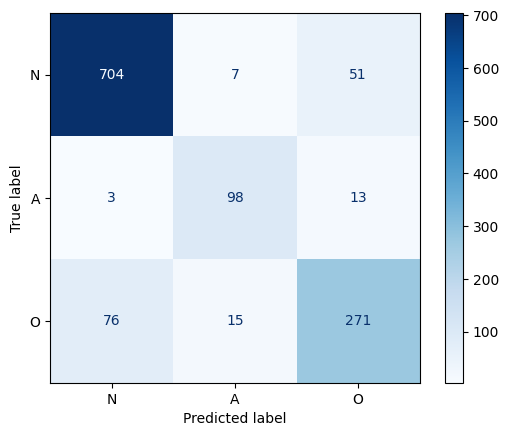

In [9]:
model = DenseNetEcgModule.load_from_checkpoint(checkpoint_callback.last_model_path)
results = trainer.predict(model, dataloaders=dm)
test_loss, test_y_pred, test_y, test_y_hat = aggregate_metrics(results)

# loss
print(f"test_loss: {test_loss}")

# auprc
test_auprc = multiclass_average_precision(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auprc: {test_auprc}")

# auroc
test_auroc = multiclass_auroc(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auroc: {test_auroc}")

# classification report
print(classification_report(test_y, test_y_hat, target_names=dm.test_set.classes))

# confusion matrix
test_cm = confusion_matrix(test_y, test_y_hat)
test_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=test_cm, display_labels=dm.test_set.classes
)
test_cm_disp.plot(cmap="Blues")
plt.show()

# logger
if wandb_mode != "disabled":
    wandb.log({"last_test_loss": test_loss.item()})
    wandb.log({"last_test_auprc": test_auprc.item()})
    wandb.log({"last_test_auroc": test_auroc.item()})
    wandb.log({"last_test_f1": f1_score(test_y, test_y_hat, average="macro")})
    wandb.log({"last_test_accuracy": accuracy_score(test_y, test_y_hat)})
    wandb.log({"last_test_cm": test_cm_disp.figure_})

### Best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 39.66it/s]
test_loss: 0.45592769980430603
test_auprc: 0.8757624626159668
test_auroc: 0.9282587170600891
              precision    recall  f1-score   support

           N       0.89      0.92      0.91       762
           A       0.79      0.87      0.83       114
           O       0.81      0.72      0.76       362

    accuracy                           0.86      1238
   macro avg       0.83      0.84      0.83      1238
weighted avg       0.86      0.86      0.86      1238



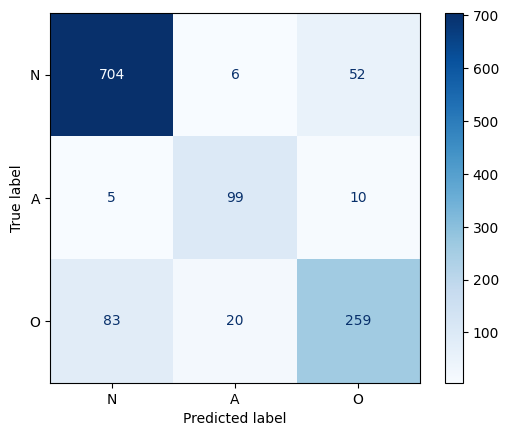

In [10]:
model = DenseNetEcgModule.load_from_checkpoint(checkpoint_callback.best_model_path)
results = trainer.predict(model, dataloaders=dm)
test_loss, test_y_pred, test_y, test_y_hat = aggregate_metrics(results)

# loss
print(f"test_loss: {test_loss}")

# auprc
test_auprc = multiclass_average_precision(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auprc: {test_auprc}")

# auroc
test_auroc = multiclass_auroc(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auroc: {test_auroc}")

# classification report
print(classification_report(test_y, test_y_hat, target_names=dm.test_set.classes))

# confusion matrix
test_cm = confusion_matrix(test_y, test_y_hat)
test_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=test_cm, display_labels=dm.test_set.classes
)
test_cm_disp.plot(cmap="Blues")
plt.show()

# logger
if wandb_mode != "disabled":
    wandb.log({"best_test_loss": test_loss.item()})
    wandb.log({"best_test_auprc": test_auprc.item()})
    wandb.log({"best_test_auroc": test_auroc.item()})
    wandb.log({"best_test_f1": f1_score(test_y, test_y_hat, average="macro")})
    wandb.log({"best_test_accuracy": accuracy_score(test_y, test_y_hat)})
    wandb.log({"best_test_cm": test_cm_disp.figure_})

In [11]:
wandb.finish()

best_test_accuracy,▁
best_test_auprc,▁
best_test_auroc,▁
best_test_f1,▁
best_test_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
last_test_accuracy,▁
last_test_auprc,▁
last_test_auroc,▁
last_test_f1,▁
last_test_loss,▁
